In [20]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import pydeck
from pywaffle import Waffle
import ipywidgets as widgets
from IPython.display import clear_output

# Load data and data preprocessing

In [2]:
def load_data():
    params = {'format' : 'json'}
    headers = headers = {
        'x-rapidapi-key': "6b39c0e054msh48c6c356e0b467ep1c76e5jsn6e7244e9217e",
        'x-rapidapi-host': "covid-19-coronavirus-statistics.p.rapidapi.com"
        }
    reponse = requests.get(f"https://covid-19-coronavirus-statistics.p.rapidapi.com/v1/stats"
                            ,headers=headers,params=params)
    data = reponse.json()
    data_c = data['data']['covid19Stats']
    df = pd.DataFrame(data_c)
    return df

In [3]:
def data_preprocessing():
    df = load_data()
    df = df.drop(['city','province'],axis=1)
    df = df.rename(columns={'lastUpdate' : 'date/time'})
    df['date/time'] = pd.to_datetime(df['date/time']).dt.tz_localize(None)
    country = {'Congo (Kinshasa)' : 'Democratic Republic of the Congo', 'Congo (Brazzaville)' : 'Republic of the Congo', 
               'Czechia' : 'Czech Republic', 'Cabo Verde' : 'Cape Verde','Taiwan*' : 'Taiwan','US' : 'United States of America',
               'Burma' : 'Myanmar','Cote d\'Ivoire' : 'Côte d\'Ivoire','Korea, South' : 'South Korea',
               'North Macedonia' : 'Macedonia'}
    df.replace({'country' : country},inplace=True)
    df.loc[df['keyId'] == 'Hong Kong, China','country'] = 'Hong Kong'
    df.loc[df['keyId'] == 'French Guiana, France','country'] = 'French Guiana'
    df.loc[df['keyId'] == 'French Polynesia, France','country'] = 'French Polynesia'
    date_arr = np.unique(df['date/time'])
    date = date_arr[len(date_arr) - 1]
    df.drop(df[df['date/time'] != date].index,inplace=True)
    df.drop(['date/time','keyId'],axis=1,inplace=True)
    return df

In [4]:
def load_data_country():
    url = 'https://raw.githubusercontent.com/VinitaSilaparasetty/covid-map/master/country-coordinates-world.csv'
    df_countries = pd.read_csv(url)
    name_of_country = {'Congo [Republic]':'Republic of the Congo', 'Congo [DRC]': 'Democratic Republic of the Congo', 
                       'Macedonia [FYROM]' : 'Macedonia','Myanmar [Burma]' : 'Myanmar'}
    df_countries.replace({'country' : name_of_country},inplace=True)
    return df_countries

In [5]:
def load_data_vaccine():
    url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/vaccine_data_global.csv'
    data_vac = pd.read_csv(url)
    data_vac = data_vac[['Country_Region','Doses_admin']]
    data_vac.rename(columns={'Country_Region' : 'country', 'Doses_admin' : 'Doses'},inplace=True)
    name_of_country = {'Czechia' : 'Czech Republic','Cote d\'Ivoire':'Côte d\'Ivoire',
                  'Congo':'Democratic Republic of the Congo','North Macedonia' : 'Macedonia',
                  'United States' : 'United States of America'}
    data_vac.replace({'country' : name_of_country},inplace=True)
    return data_vac

In [6]:
def covid_by_country_regions(dataFrame, name_of_country):
    return dataFrame[dataFrame['Country'] == name_of_country]\
            .sort_values(by=['Confirmed'],ascending=False).head(5)

In [7]:
def covid_group(dataFrame):
    df_gr = dataFrame.groupby(['country'])\
              .agg({'confirmed' : 'sum','deaths':'sum','recovered':'sum'})\
              .reset_index()
    df_gr.replace(np.NaN,0,inplace=True)
    df_vacc = load_data_vaccine()
    df_gr = pd.merge(df_gr,df_vacc,on='country',how='left')
    df_region = pd.read_csv('region.csv',sep=';')
    df_gr = pd.merge(df_gr,df_region,on='country',how='left')
    df_gr.columns = df_gr.columns.str.capitalize()
    return df_gr

In [8]:
def covid_all(dataFrame):
    df_gr =  covid_group(dataFrame)
    df_countries = load_data_country()
    df_all = pd.merge(df_gr,df_countries,on='Country',how='left')
    return df_all

In [45]:
###Code of each feature

In [46]:
#display data

In [43]:
dataFrame = data_preprocessing()
df_gr = covid_group(dataFrame)
Previous_button = widgets.Button(description='Previous')
Next_button = widgets.Button(description='Next')
out = widgets.Output()
count = [0,5]
def next_button_click(_,inner=1):
    with out:
        clear_output(wait=True)
        if count[1] == 195 and inner==1:
            count[0] = 0
            count[1] = 5
            display(df_gr[count[0] : count[1]])
        elif count[0] == 0 and inner==-1:
            count[0] = 190
            count[1] = 195
            display(df_gr[count[0] : count[1]])
        else:
            count[0] += 5*inner
            count[1] += 5*inner
            display(df_gr[count[0] : count[1]])
Next_button.on_click(next_button_click)

def previous_button_click(_,inner=1):
    return next_button_click(_,-1)
            
Previous_button.on_click(previous_button_click)


In [128]:
### Banner

In [27]:
def covid_banner_worldcloud(dataFrame):
    mask = np.array(Image.open('covid19_logo.png'))
    df_gr = covid_group(dataFrame)
    country = df_gr['Country'].values
    wordcloud_cv = WordCloud(background_color="mistyrose", mode="RGB", max_words=195, mask=mask).generate(str(country))
    plt.figure(figsize=[20,15])
    plt.imshow(wordcloud_cv,interpolation="bilinear")#.recolor(color_func=image_colors))
    plt.axis("off")
    plt.show()

In [28]:
### Summary in the world

In [29]:
def summary_world(dataFrame):
    df_total = covid_group(dataFrame).sum(axis=0).to_frame()
    df_total = df_total.transpose()
    df_total.drop(['Country'],axis=1,inplace=True)
    display(df_total)

In [30]:
### Map summary

In [31]:
def plotDot(point):
    popup_text = "{}<br> Confirmed: {:,}<br> Deaths: {:,}<br> Doses: {:,}"
    popup_text = popup_text.format(
                      point['Country'],
                      point["Confirmed"],
                      point["Deaths"],
                      point['Doses']
                      )
    FCM = folium.CircleMarker(location=(point['latitude'],point['longitude']),
                       radius=5,
                       weight=2,
                       popup=popup_text,
                       fill_color ='#00000000')
    return FCM
def map_covid(datFrame):
    # read data
    df_all = covid_all(dataFrame)
    
    # Create base map and choropleth map
    url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
    )
    country_shapes = f'{url}/world-countries.json'
    M = folium.Map(titles='StamenToner',min_zoom=1.5)
    folium.Choropleth(
        geo_data=country_shapes,
        min_zoom=2,
        name='COVID-19.2021',
        data = df_all,
        columns=['Country','Confirmed'],
        key_on='feature.properties.name',
        fill_color='OrRd',
        nan_fill_color='pink',
        legend_name='Total Confirmed Covid Case',
    ).add_to(M)
    # processing Dataframe
    df_all.dropna(subset=['longitude','latitude'],inplace=True)
    
    # apply data
    df_all.apply(lambda x: plotDot(x).add_to(M),axis=1)
    M.fit_bounds(M.get_bounds())
    return M
M = map_covid(dataFrame)

In [ ]:
### Covid in countries

In [32]:
country_list = np.unique(dataFrame['country'])
country_d = widgets.Dropdown(
    options = country_list,
    value = 'Vietnam',
    description = 'Country'
)
def cot_show(country):
    df_co = covid_by_country_regions(covid_group(dataFrame),country)
    display(df_co)
    deaths_p = ((df_co['Deaths'].values[0])*100/(df_co['Confirmed'].values[0]))
    statistic=[deaths_p,(100 - deaths_p)]
    labels_st=['deaths: ' + str(round(deaths_p,2)) + '%', 'recovering and recoverd']
    # Waffle chart of the world
    fig = plt.figure(
        FigureClass=Waffle,
        values = statistic,
        rows=5,
        labels = labels_st,
        icons = 'child',
        font_size = 10,
        icon_legend=True,
        legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
        figsize = (10,10),# figsize is a parameter of plt.figure,'the proportion in 100 people'
        title={'label': 'The proportion of death in 100 people confirmed in ' + country , 'loc': 'left'}
    )
cot = widgets.interactive(cot_show,country=country_d)

In [ ]:
### Covid-19 in each continent

In [33]:
choices = widgets.RadioButtons(
                options=['Confirmed','Deaths','Doses'],
                desciption='Choose:',
                disabled=False
                )

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.2f}%".format(pct, absolute)


def continent_data():
    df_continentia = covid_group(dataFrame).groupby('Continent').agg({'Confirmed' : 'sum','Deaths':'sum',
                                                                      'Recovered':'sum','Doses' : 'sum'})
    return df_continentia


def continent_show(Choose):
    df_continentia = continent_data()
    continent = df_continentia.index
    data=np.asarray(df_continentia[Choose])
    # Creating explode data
    explode = (0.3, 0.1, 0.1, 0.1, 0.1, 0.1)
  
    # Creating color parameters
    if Choose == 'Deaths':
        colors = ( "orange", "cyan", "brown",
                  "grey", "violet", "bisque")
    elif Choose=='Doses':
        colors = ("deepskyblue", "mediumspringgreen", "yellow",
                  "tomato", "rosybrown", "silver")
    else:
        colors = ("lightskyblue", "palegreen", "lemonchiffon",
                  "peachpuff", "lightsalmon", "pink")
  
    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "green" }
  

  
    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(data, 
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode, 
                                      labels = continent,
                                      shadow = True,
                                      colors = colors,
                                      startangle = 90,
                                      wedgeprops = wp,
                                      textprops = dict(color ="black"))
  
    # Adding legend
    ax.legend(wedges, continent,
              title ="Continent",
              loc ="center left",
              bbox_to_anchor =(1.5, 0, 0.5, 1))
  
    plt.setp(autotexts, size = 8, weight ="bold")
    if Choose == 'Doses':
        ax.set_title('Vaccine to againt covid-19', y = -0.1)
    else:
        ax.set_title('The cases of covid-19 is ' + str(Choose).lower(), y = -0.1)  
    # show plot
    plt.show()
show_data = widgets.interactive(continent_show,Choose=choices)

### Display data

In [44]:
buttons = widgets.HBox([Previous_button,Next_button])
widgets.VBox([buttons,out])

# Interactive data and visualize

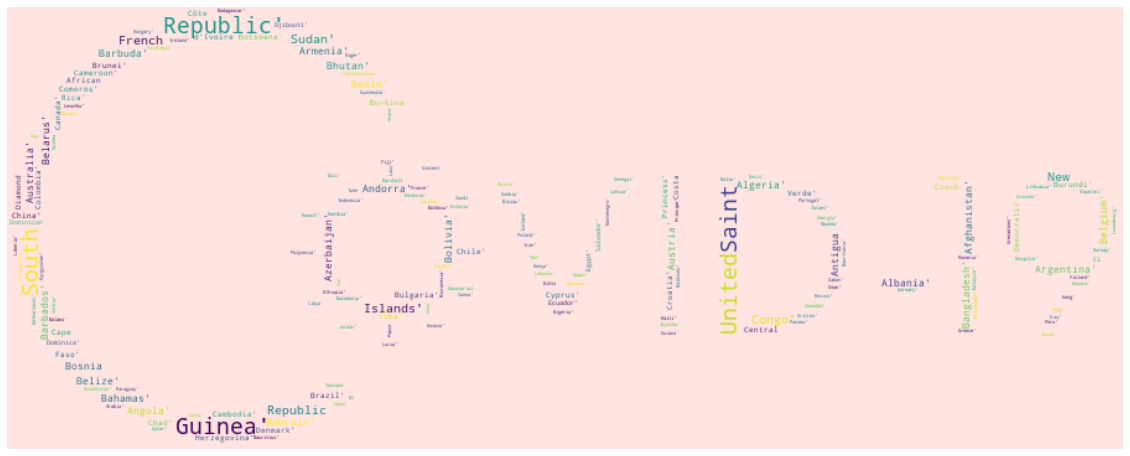

In [34]:
covid_banner_worldcloud(dataFrame)

### Cases Around the world

In [36]:
summary_world(dataFrame)
M

,Confirmed,Deaths,Recovered,Doses
0,149622699,3150671,86843026.0,1087116042.0


### The Covid-19 in countries

In [37]:
display(cot)

interactive(children=(Dropdown(description='Country', index=190, options=('Afghanistan', 'Albania', 'Algeria',…

### The covid-19 statistic in each continent

In [38]:
display(continent_data())
display(show_data)

,Confirmed,Deaths,Recovered,Doses
Continent,,,,
Africa,4522028,121019,4040624.0,17585854.0
Asia,38557276,510176,33010323.0,506503002.0
Europe,44473247,1009984,23399438.0,215877407.0
Latin America and the Caribbean,28555081,909730,25234643.0,94636151.0
Northern America,33441603,598446,1107435.0,250186759.0
Oceania,62190,1187,39545.0,2325922.0


interactive(children=(RadioButtons(description='Choose', options=('Confirmed', 'Deaths', 'Doses'), value='Conf…